To do:

- Try wilcoxon test to compare two distributions
- ~~Feature selection One-vs-many seems to give good seperation~~ This may not be the case -- implemented ``majority``, but the accuracy is not high
- Try to find the best scoring function

### Load Context

In [1]:
import os
import sys
import scipy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
os.chdir("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/")
sys.path.append("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")

params = catalog.load('parameters')

data = catalog.load("data_proc")
vocab = catalog.load("vocabulary")

known_authors = params['known_authors']

2022-03-30 09:04:58,675 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...
2022-03-30 09:04:58,676 - kedro.io.data_catalog - INFO - Loading data from `data_proc` (CSVDataSet)...
2022-03-30 09:04:58,825 - kedro.io.data_catalog - INFO - Loading data from `vocabulary` (CSVDataSet)...


In [2]:
import numpy as np
from scipy.stats import f as fdist
from scipy.stats import t as tdist
from scipy.stats import norm
from scipy.stats import ttest_ind as ttest
from scipy.stats import levene
from scipy.stats import bartlett

def discrepancy(cnt1, cnt2, **kwargs):
    
    disc_type = kwargs.get('test', 'HC')
    gamma = kwargs.get('gamma', .2)
    
    pvals = bin_allocation_test(cnt1, cnt2)
    mt = MultiTest(pvals)
    if disc_type == 'HC':
        hc,_ = mt.hc_star(gamma = gamma)
        return hc
    if disc_type == 'Fisher':
        return np.mean(-np.log(pvals))
    
    raise ValueError("Only HC-discrepancy is supported")

def merge_list_of_dataframes(lo_df):
    dfr = pd.DataFrame()
    for df in lo_df:
        dfr = dfr.append(df, ignore_index=True)
    return dfr
        
class CompareDocsRelativeResponse(object):
    """
    Upon call, this object need to return 
    HC discrepancy of two points
    
    Can use CompareDocs model but does not have to
    The issue is how to decide on a vocabulary
    
    """
    def __init__(self, compare_docs_model, discrepancy_type='HC'):
        self.cd_model = compare_docs_model
        self.disc_type = discrepancy_type
        

    def __call__(self, X1, X2):
        cnt1 = self.cd_model.count_words(merge_list_of_dataframes(X1)).n
        cnt2 = self.cd_model.count_words(merge_list_of_dataframes(X2)).n
        return discrepancy(cnt1, cnt2, disc_type=self.disc_type)
    

def test_f(scores0, scores1):
    def _sum_of_squares(scores):
            return np.sum((scores - np.mean(scores)) ** 2)
        
    ss0 = _sum_of_squares(scores0)
    ss1 = _sum_of_squares(scores1)
    fstat = ss1 / ss0
    return fstat, fdist.sf(ss1 / ss0, dfn=len(scores1)-1,dfd=len(scores0)-1)


def test_bartlett(scores0, scores1):
    return bartlett(scores0, scores1)


def test_t_2smp(scores0, scores1):
    return ttest(scores0, scores1)


def test_t(scores0, scores1):
    mu = np.mean(scores1[:-1])
    t = (scores1[-1] - mu) / np.std(scores1[:-1], ddof=1)
    return t, tdist.sf(t, df=len(scores1) - 2) # one-sided


def test_wilcoxon(scores0, scores1):
    return scipy.stats.ranksums(scores0, scores1)

def test_perm(scores0, scores1):
    """
    Two-sample permutation test
    """
    return ttest(scores0, scores1, permutations=5000)

def test_linear(scores0, scores1):
    mu = np.mean(scores0)
    t = (scores1[-1] - mu) / np.std(scores0, ddof=1)
    return t, tdist.sf(t, df=len(scores0) - 1) # one-sided


def test_levene(scores0, scores1):
    return levene(scores0, scores1)

In [3]:
from twosample import bin_allocation_test
from multitest import MultiTest
from typing import List

        
class AnovaClassifier(object):
    """
    ANOVA-based classification using a base
    response model. The relative response function is provided 
    in the fitting stage
    """
    
    def __init__(self):
        self._data = {}
        self.rr_func = None
        self.classes_ = []
        self.no_samples = {}
    
    def fit(self, relative_response_func, X: List, y: List):
        """
        
        Params:
            :relative_response_model: a model with method 'predict' 
            that returns the relative response of two datasets
            
            :X:   data
            :y:   labels
            
        """
        self.rr_func = relative_response_func
        self.no_samples = {}
        self._data = {}
        self.classes_ = list(np.unique(y))
        self.scores_ = {}
        for cls in self.classes_:
            X_cls = [X[i] for i,label in enumerate(y) if label == cls]
            self._data[cls] = X_cls
            self.scores_[cls] = self._within_corpus_disc(X_cls)
            self.no_samples[cls] = len(X_cls)
            
    def predict(self, x):
        probs = self.predict_proba(x)
        res = {}
        for k in probs:
            res[k] = -np.log(probs[k])
        return res
        
    def predict_table(self, x):
        df = pd.DataFrame()
        for cls in self.classes_:
            X_extended = self._data[cls] + [x]
            scores1 = self._within_corpus_disc(X_extended)
            scores0 = self.scores_[cls]
            stat, pval = self.test(scores0, scores1)
            df = df.append({'cls' : cls,
                            'scores1' : scores1,
                            'scores0' : scores0,
                            'n1' : len(scores0),
                            'n2' : len(scores1),
                            'stat' : stat, 
                            'pval' : pval
                           }, ignore_index=True)
        return df
        
    def predict_many(self, x):
        df = pd.DataFrame()
        for cls in self.classes_:
            X_extended = self._data[cls] + [x]
            scores1 = self._within_corpus_disc(X_extended)
            scores0 = self.scores_[cls]
            res = self.many_tests(scores0, scores1)
            dfr = dict({'cls' : cls,
                   'n1' : len(scores0),
                   'n2' : len(scores1),
                    **res})
            df = df.append(dfr, ignore_index=True)
        return df
            
    def predict_proba(self, x):
        """
        Returns class probabilities
        
        Probabilites are obtained via f-test:
        SS of each class with x included versue SS without x
        """
        df = self.predict_table(x)
        probs = dict(zip(df.cls, df.pval))
        return probs
    
    
    def test(self, scores0, scores1):
        return test_t(scores0, scores1)
    
    
    def many_tests(self, scores0, scores1):
        return dict(
        raw = scores1[-1], 
        pval_t = test_t(scores0, scores1)[1],
        pval_f = test_f(scores0, scores1)[1],
        pval_bartlett = test_bartlett(scores0, scores1)[1],
        pval_2smp = test_t_2smp(scores0, scores1)[1],
        pval_tLDA = test_linear(scores0, scores1)[1],
        pval_levene = test_levene(scores0, scores1)[1],
        pval_wilcox = test_wilcoxon(scores0, scores1).pvalue,
        pval_2smp_perm = test_perm(scores0, scores1)[1]
        )
        
        
    def _within_corpus_disc(self, X: List):
        """
        Find relative response of each element in X compared to the other elements.
        
        Params:
            :X:  data
        
        Returns:
            :scores:     relative response
        """
        scores = np.zeros(len(X))
        for i,x in enumerate(X):
            scores[i] = self.rr_func([x], [X[j] for j,_ in enumerate(X) if j != i])
        return scores
        

In [4]:
class OneVsMany(object):
    def __init__(self):
        pass
    
    def fit(self, X: List, y: List):
        self.classes_ = list(np.unique(y))
        pass
    
    def fit_MultiDoc(self, md):
        self.classes_ = md.cls_names
        self.md = md
        df = md.HCT_vs_many()
        cls_df = {}
        cls_scores = {}
        for cls_name in self.classes_:
            cls_df[cls_name] = df[df[f'{cls_name}:affinity'] != 0]
        self.cls_df = cls_df
        
    def fit_class_means(self, md, train_data):
        """
        Evaluate distribution over training data for improved
        prediction. 
        
        :md:  MultiDoc model
        """
        
        lo_docs = train_data.doc_id.unique()
        res = {}
        for cls_name in self.classes_:
            res[cls_name] = []
        for doc in lo_docs:
            ds1 = train_data[train_data.doc_id == doc]
            class_of_doc = ds1.author.unique()[0]
            r = self.md.test_doc_mask(ds1, of_cls=class_of_doc)
            df = r[class_of_doc]['df']
            df0 = df.filter(like=rf'{class_of_doc}:')
            df0 = pd.concat([df0, df.filter(like=rf'tested:')], axis=1)
            df0['n'] = df['n']
            df0['T'] = df['T']
            df0 = df0.rename(columns={f'{class_of_doc}:affinity' : 'class:affinity'})
            s = two_df_response(df0, df)
            res[class_of_doc].append(s)
        self.cls_scores = res
        return res
        
    def predict_response(self, x):
        res = {}
        for cls_name in self.classes_:
            df0 = self.cls_df[cls_name].rename(columns={f'{cls_name}:affinity' : 'class:affinity'})
            res[cls_name] = two_df_response(df0, self.md.test_doc(x))
        return res
    
    def predict_proba(self, x):
        res = self.predict_response(x)
        prob = {}
        for cls in self.classes_:
            v = self.cls_scores[cls]
            z = (res[cls] - np.mean(v)) / np.std(v)
            prob[cls] = 1 / np.abs(z)
        return prob

def two_df_response(df0, df1):
    """
    Evaluate the response of df1 wrt df0 
    where df0 and df1 are dataframes obtained
    from MultiDoc testing functions
    
    For df0, we use 'class:affinity' column
    """
    dft = df0.join(df1, how='left', rsuffix='_t')
    #dft['tested:s'] = (2*(dft['tested:n'] / dft['tested:T'] > dft['n'] / dft['T']) - 1) * dft[f'class:affinity']
    #dft['tested:s'] =  (dft['tested:n'] / dft['tested:T'] > dft['n'] / dft['T']) & (dft[f'class:affinity'] > 0)
    dft['tested:s'] = dft['tested:n'] / dft['tested:T'] * dft[f'class:affinity']
    return dft['tested:s'].mean()


In [5]:
from biblical_scripts.pipelines.sim.nodes import (
    build_model, model_predict, _prepare_data)
from sklearn.model_selection import KFold

In [6]:
data = _prepare_data(data[data.to_report])
data_known = data[data.author.isin(known_authors)]
lo_docs = data_known.doc_id.unique()

2022-03-30 09:05:06,519 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [9]:
df_res = pd.DataFrame()
for doc in tqdm(lo_docs): # leave-one-out
    ds1 = data_known[data_known.doc_id == doc]
    data_train = data_known.drop(ds1.index) # leave-one-out
    md, vocab = build_model(data_train, vocab, params['model'])
    om = OneVsMany()
    om.fit_MultiDoc(md)
    om.fit_class_means(md, data_train)
    r = om.predict_proba(ds1)
    #r = om.predict_response(ds1)
    res = pd.DataFrame(r, index = ['avg']).T.reset_index().rename(columns={'index' : 'cls'})
    res['doc_tested'] = doc
    res['len'] = len(ds1)
    df_res = df_res.append(res, ignore_index=True)

  0%|          | 0/49 [00:00<?, ?it/s]

2022-03-22 09:56:05,985 - root - INFO - Building CompareDocs model using 48 documents. 


  2%|▏         | 1/49 [00:01<01:02,  1.30s/it]

2022-03-22 09:56:07,281 - root - INFO - Building CompareDocs model using 48 documents. 


  4%|▍         | 2/49 [00:02<00:59,  1.26s/it]

2022-03-22 09:56:08,516 - root - INFO - Building CompareDocs model using 48 documents. 


  6%|▌         | 3/49 [00:03<00:57,  1.25s/it]

2022-03-22 09:56:09,750 - root - INFO - Building CompareDocs model using 48 documents. 


  6%|▌         | 3/49 [00:04<01:04,  1.40s/it]


KeyboardInterrupt: 

In [7]:
def arrange_training_data(data):
    X = []
    y = []
    lo_authors = data.author.unique()
    for auth in lo_authors:
        ds_auth = data[data.author == auth]
        lo_docs = ds_auth.doc_id.unique()
        Xauth = [c[1] for c in ds_auth.groupby('doc_id')]
        X += Xauth
        y += [auth] * len(Xauth)
    return X, y

df_res = pd.DataFrame()
for doc in tqdm(lo_docs): # leave-one-out
    ds1 = data_known[data_known.doc_id == doc]
    data_train = data_known.drop(ds1.index) # leave-one-out
    md, vocab = build_model(data_train, vocab, params['model'])
    cdrr = CompareDocsRelativeResponse(md)
    
    X, y = arrange_training_data(data_train)
    anova_cls = AnovaClassifier()
    anova_cls.fit(cdrr, X, y)
    
    res = anova_cls.predict_many(ds1)
    res['doc_tested'] = doc
    res['len'] = len(ds1)
    df_res = df_res.append(res, ignore_index=True)

  0%|          | 0/50 [00:00<?, ?it/s]

2022-03-30 09:05:10,292 - root - INFO - Building CompareDocs model using 49 documents. 


  2%|▏         | 1/50 [00:03<03:04,  3.76s/it]

2022-03-30 09:05:14,047 - root - INFO - Building CompareDocs model using 49 documents. 


  4%|▍         | 2/50 [00:07<02:58,  3.72s/it]

2022-03-30 09:05:17,731 - root - INFO - Building CompareDocs model using 49 documents. 


  6%|▌         | 3/50 [00:11<02:53,  3.70s/it]

2022-03-30 09:05:21,407 - root - INFO - Building CompareDocs model using 49 documents. 


  8%|▊         | 4/50 [00:14<02:50,  3.71s/it]

2022-03-30 09:05:25,144 - root - INFO - Building CompareDocs model using 49 documents. 


 10%|█         | 5/50 [00:18<02:46,  3.70s/it]

2022-03-30 09:05:28,828 - root - INFO - Building CompareDocs model using 49 documents. 


 12%|█▏        | 6/50 [00:22<02:42,  3.69s/it]

2022-03-30 09:05:32,503 - root - INFO - Building CompareDocs model using 49 documents. 


 14%|█▍        | 7/50 [00:25<02:38,  3.69s/it]

2022-03-30 09:05:36,186 - root - INFO - Building CompareDocs model using 49 documents. 


 16%|█▌        | 8/50 [00:29<02:35,  3.70s/it]

2022-03-30 09:05:39,921 - root - INFO - Building CompareDocs model using 49 documents. 


 18%|█▊        | 9/50 [00:33<02:32,  3.71s/it]

2022-03-30 09:05:43,635 - root - INFO - Building CompareDocs model using 49 documents. 


 20%|██        | 10/50 [00:36<02:26,  3.66s/it]

2022-03-30 09:05:47,180 - root - INFO - Building CompareDocs model using 49 documents. 


 22%|██▏       | 11/50 [00:40<02:21,  3.64s/it]

2022-03-30 09:05:50,782 - root - INFO - Building CompareDocs model using 49 documents. 


 24%|██▍       | 12/50 [00:44<02:21,  3.71s/it]

2022-03-30 09:05:54,667 - root - INFO - Building CompareDocs model using 49 documents. 


 26%|██▌       | 13/50 [00:48<02:19,  3.77s/it]

2022-03-30 09:05:58,568 - root - INFO - Building CompareDocs model using 49 documents. 


 28%|██▊       | 14/50 [00:52<02:21,  3.93s/it]

2022-03-30 09:06:02,877 - root - INFO - Building CompareDocs model using 49 documents. 


 30%|███       | 15/50 [00:56<02:19,  4.00s/it]

2022-03-30 09:06:07,028 - root - INFO - Building CompareDocs model using 49 documents. 


 32%|███▏      | 16/50 [01:00<02:12,  3.89s/it]

2022-03-30 09:06:10,664 - root - INFO - Building CompareDocs model using 49 documents. 


 34%|███▍      | 17/50 [01:03<02:05,  3.80s/it]

2022-03-30 09:06:14,259 - root - INFO - Building CompareDocs model using 49 documents. 


 36%|███▌      | 18/50 [01:07<01:59,  3.74s/it]

2022-03-30 09:06:17,860 - root - INFO - Building CompareDocs model using 49 documents. 


 38%|███▊      | 19/50 [01:11<01:55,  3.72s/it]

2022-03-30 09:06:21,536 - root - INFO - Building CompareDocs model using 49 documents. 


 40%|████      | 20/50 [01:15<01:52,  3.74s/it]

2022-03-30 09:06:25,324 - root - INFO - Building CompareDocs model using 49 documents. 


 42%|████▏     | 21/50 [01:18<01:47,  3.70s/it]

2022-03-30 09:06:28,939 - root - INFO - Building CompareDocs model using 49 documents. 


 44%|████▍     | 22/50 [01:22<01:43,  3.69s/it]

2022-03-30 09:06:32,601 - root - INFO - Building CompareDocs model using 49 documents. 


 46%|████▌     | 23/50 [01:25<01:39,  3.67s/it]

2022-03-30 09:06:36,235 - root - INFO - Building CompareDocs model using 49 documents. 


 48%|████▊     | 24/50 [01:29<01:35,  3.69s/it]

2022-03-30 09:06:39,964 - root - INFO - Building CompareDocs model using 49 documents. 


 50%|█████     | 25/50 [01:33<01:33,  3.73s/it]

2022-03-30 09:06:43,774 - root - INFO - Building CompareDocs model using 49 documents. 


 52%|█████▏    | 26/50 [01:37<01:28,  3.70s/it]

2022-03-30 09:06:47,419 - root - INFO - Building CompareDocs model using 49 documents. 


 54%|█████▍    | 27/50 [01:40<01:25,  3.70s/it]

2022-03-30 09:06:51,112 - root - INFO - Building CompareDocs model using 49 documents. 


 56%|█████▌    | 28/50 [01:44<01:21,  3.73s/it]

2022-03-30 09:06:54,900 - root - INFO - Building CompareDocs model using 49 documents. 


 58%|█████▊    | 29/50 [01:48<01:17,  3.71s/it]

2022-03-30 09:06:58,580 - root - INFO - Building CompareDocs model using 49 documents. 


 60%|██████    | 30/50 [01:51<01:13,  3.67s/it]

2022-03-30 09:07:02,157 - root - INFO - Building CompareDocs model using 49 documents. 


 62%|██████▏   | 31/50 [01:55<01:09,  3.64s/it]

2022-03-30 09:07:05,727 - root - INFO - Building CompareDocs model using 49 documents. 


 64%|██████▍   | 32/50 [01:59<01:05,  3.64s/it]

2022-03-30 09:07:09,356 - root - INFO - Building CompareDocs model using 49 documents. 


 66%|██████▌   | 33/50 [02:02<01:01,  3.64s/it]

2022-03-30 09:07:12,992 - root - INFO - Building CompareDocs model using 49 documents. 


 68%|██████▊   | 34/50 [02:06<00:58,  3.63s/it]

2022-03-30 09:07:16,599 - root - INFO - Building CompareDocs model using 49 documents. 


 70%|███████   | 35/50 [02:09<00:54,  3.62s/it]

2022-03-30 09:07:20,185 - root - INFO - Building CompareDocs model using 49 documents. 


 72%|███████▏  | 36/50 [02:13<00:50,  3.62s/it]

2022-03-30 09:07:23,805 - root - INFO - Building CompareDocs model using 49 documents. 


 74%|███████▍  | 37/50 [02:17<00:46,  3.61s/it]

2022-03-30 09:07:27,411 - root - INFO - Building CompareDocs model using 49 documents. 


 76%|███████▌  | 38/50 [02:20<00:43,  3.64s/it]

2022-03-30 09:07:31,128 - root - INFO - Building CompareDocs model using 49 documents. 


 78%|███████▊  | 39/50 [02:24<00:40,  3.68s/it]

2022-03-30 09:07:34,900 - root - INFO - Building CompareDocs model using 49 documents. 


 80%|████████  | 40/50 [02:28<00:37,  3.75s/it]

2022-03-30 09:07:38,810 - root - INFO - Building CompareDocs model using 49 documents. 


 82%|████████▏ | 41/50 [02:32<00:33,  3.70s/it]

2022-03-30 09:07:42,404 - root - INFO - Building CompareDocs model using 49 documents. 


 84%|████████▍ | 42/50 [02:35<00:29,  3.71s/it]

2022-03-30 09:07:46,126 - root - INFO - Building CompareDocs model using 49 documents. 


 86%|████████▌ | 43/50 [02:39<00:26,  3.73s/it]

2022-03-30 09:07:49,909 - root - INFO - Building CompareDocs model using 49 documents. 


 88%|████████▊ | 44/50 [02:43<00:22,  3.75s/it]

2022-03-30 09:07:53,708 - root - INFO - Building CompareDocs model using 49 documents. 


 90%|█████████ | 45/50 [02:47<00:18,  3.70s/it]

2022-03-30 09:07:57,285 - root - INFO - Building CompareDocs model using 49 documents. 


 92%|█████████▏| 46/50 [02:50<00:14,  3.68s/it]

2022-03-30 09:08:00,924 - root - INFO - Building CompareDocs model using 49 documents. 


 94%|█████████▍| 47/50 [02:54<00:11,  3.72s/it]

2022-03-30 09:08:04,735 - root - INFO - Building CompareDocs model using 49 documents. 


 96%|█████████▌| 48/50 [02:58<00:07,  3.77s/it]

2022-03-30 09:08:08,619 - root - INFO - Building CompareDocs model using 49 documents. 


 98%|█████████▊| 49/50 [03:02<00:03,  3.80s/it]

2022-03-30 09:08:12,501 - root - INFO - Building CompareDocs model using 49 documents. 


100%|██████████| 50/50 [03:05<00:00,  3.72s/it]


In [8]:
scores0 = anova_cls.scores_['Dtr']
scores1 = anova_cls.scores_['P']

In [12]:
df_res.loc[: ,'true_class'] = df_res.doc_tested.apply(lambda x : x.split('|')[0])
#df_res.loc[:, 'neg_raw'] = -df_res['raw']

for value in df_res.columns[df_res.columns.str.contains(r'pval|neg_raw|avg')]:        
    idx = df_res.groupby('doc_tested')[value].idxmax(axis=1)
    acc = np.mean(df_res.loc[idx, 'cls'] == df_res.loc[idx, 'true_class'])
    print(f"Accuracy with {value} = {acc}")
    #df_res['predicted_class'] = df_res[['Dtr', 'DtrH', 'P']].idxmin(axis=1)
    #print("Accuracy: ", np.mean(df_res.predicted_class == df_res.true_class))

Accuracy with pval_2smp = 0.56
Accuracy with pval_2smp_perm = 0.56
Accuracy with pval_bartlett = 0.48
Accuracy with pval_f = 0.76
Accuracy with pval_levene = 0.36
Accuracy with pval_t = 0.84
Accuracy with pval_tLDA = 0.84
Accuracy with pval_wilcox = 0.54


In [13]:
probs = catalog.load('probs')
df_res.filter(['cls', 'n1', 'n2', 'doc_tested', 'raw', 'len', 'true_class', 'pval_tLDA', 'pval_t'])

2022-03-30 09:13:16,254 - kedro.io.data_catalog - INFO - Loading data from `probs` (CSVDataSet)...


,cls,n1,n2,doc_tested,raw,len,true_class,pval_tLDA,pval_t
0,Dtr,8.0,9.0,Dtr|Deut.6,-0.341942,540,Dtr,0.977765,0.962355
1,DtrH,19.0,20.0,Dtr|Deut.6,1.073515,540,Dtr,0.912597,0.911454
2,P,22.0,23.0,Dtr|Deut.6,4.275162,540,Dtr,0.219474,0.231545
3,Dtr,8.0,9.0,Dtr|Deut.12,1.409820,855,Dtr,0.465212,0.454522
4,DtrH,19.0,20.0,Dtr|Deut.12,4.376707,855,Dtr,0.022752,0.016175
...,...,...,...,...,...,...,...,...,...
145,DtrH,19.0,20.0,P|Lev.8,6.508046,902,P,0.000156,0.000238
146,P,21.0,22.0,P|Lev.8,2.641063,902,P,0.838826,0.831466
147,Dtr,9.0,10.0,P|Lev.9,3.769937,527,P,0.021319,0.033225
148,DtrH,19.0,20.0,P|Lev.9,4.379119,527,P,0.022635,0.019885


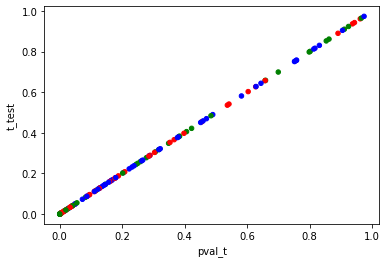

<ipython-input-14-78affc20f15e>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-14-78affc20f15e>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,cls,n1,n2,doc_tested,raw,true_class,pval_tLDA,pval_t,t-score,t_test,"('value', 'mean')","('value', 'count')"


In [14]:
df = df_res.merge(probs.rename(columns={'corpus' : 'cls'}), on=['doc_tested', 'cls'])
df['t_test'] = np.exp(-df['t_test'])
df1 = df.filter(['cls', 'n1', 'n2', 'doc_tested', 'raw', 'len', 'true_class', 'pval_tLDA', 'pval_t', 't-score', 't_test', "('value', 'mean')", "('value', 'count')"])


color_dic = {'Dtr' : 'red', 'DtrH' : 'green', 'P' : 'blue'}
colors = [color_dic[a] for a in df1['cls'].values]

df1.plot.scatter(x='pval_t', y='t_test', color=colors)
plt.show()

df1[df1.cls == 'Dtr'][df1.true_class == 'Dtr'][df1.t_test/df1.pval_t > 1.1]

In [15]:
dfr = df_res.filter(regex=r'(pval_|raw|cls|doc_tested|true_class|avg)').pivot(columns = 'cls', index='doc_tested')

In [16]:
color_dic = {'Dtr' : 'red', 'DtrH' : 'green', 'P' : 'blue'}
colors = [color_dic[a] for a in dfr['true_class']['P'].values]

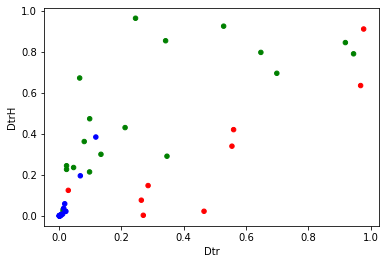

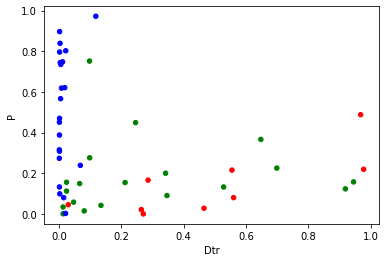

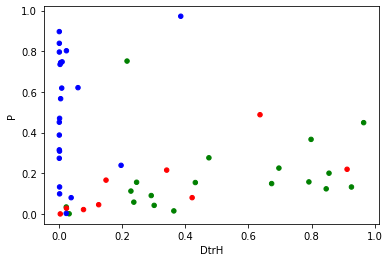

In [17]:
value = 'pval_tLDA'

for cls1 in ['Dtr', 'DtrH', 'P'] :
    for cls2 in ['Dtr', 'DtrH', 'P']:
        if cls1 < cls2:
            dfr.plot.scatter(x=(value, cls1), y=(value, cls2),
                             color=colors)
            #plt.xlim((0,0.1))
            #plt.ylim((0,0.1))
            plt.xlabel(cls1)
            plt.ylabel(cls2)
            plt.show()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])